# Tutorial 2 - Spatial Network analysis

**Lesson objectives**

This tutorial focuses on **spatial networks** and learn how to construct a routable **directed** graph for Networkx and find shortest paths along the given street network based on travel times or distance by car. 

## Tutorial

In this tutorial we will focus on a network analysis methods that relate to way-finding.
Finding a shortest path from A to B using a specific street network is a very common spatial analytics
problem that has many practical applications.

Python provides easy to use tools for conducting spatial network analysis.
One of the easiest ways to start is to use a library
called [Networkx](https://networkx.github.io/documentation/stable/)
which is a Python module that provides a lot tools that can be used to
analyze networks on various different ways. It also contains algorithms
such as [Dijkstra’s
algorithm](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.weighted.single_source_dijkstra.html#networkx.algorithms.shortest_paths.weighted.single_source_dijkstra)
or [A\*](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.shortest_paths.astar.astar_path.html#networkx.algorithms.shortest_paths.astar.astar_path)
algoritm that are commonly used to find shortest paths along
transportation network.

Next, we will learn how to do spatial network analysis in practice.

## Typical workflow for routing

If you want to conduct network analysis (in any programming language) there are a few basic steps that typically needs to be done before you can start routing. These steps are:

 1. **Retrieve data** (such as street network from OSM or Digiroad + possibly transit data if routing with PT).
 2. **Modify the network** by adding/calculating edge weights (such as travel times based on speed limit and length of the road segment).
 3. **Build a routable graph** for the routing tool that you are using (e.g. for NetworkX, igraph or OpenTripPlanner).
 4. **Conduct network analysis** (such as shortest path analysis) with the routing tool of your choice. 

## 1. Retrieve data

As a first step, we need to obtain data for routing. [osmnx](https://osmnx.readthedocs.io/en/stable/) library makes it really easy to retrieve routable networks from OpenStreetMap (OSM) with different transport modes (walking, cycling and driving). 

Let's first extract OSM data for Helsinki city centre that are drivable by car. In `osmnx`, we can use a function called `ox.graph_from_place()` which retrieves data from OpenStreetMap. It is possible to specify what kind of roads should be retrieved from OSM with `network_type` -parameter (supports e.g. `walk`, `drive`, `bike`, `all`). In the following, we fetch all the drivable roads from "Kamppi, Helsinki":

In [7]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import networkx as nx

# The area of interest
query = "Kamppi, Helsinki"

# We will use test data for Helsinki that comes with pyrosm
G = ox.graph_from_place(query, network_type="drive", simplify=False)

type(G)

/Users/tenkanh2/micromamba/envs/geo/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/tenkanh2/micromamba/envs/geo/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/tenkanh2/micromamba/envs/geo/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/tenkanh2/micromamba/envs/geo/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/tenkanh2/micromamba/envs/geo/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


networkx.classes.multidigraph.MultiDiGraph

Okay, as we can see we have now fetched a routable graph out of OpenStreetMap data of ours which is something called `MultiDiGraph` object of `networkx` library. Let's remind us about the basic elements of a graph that we went through in the lecture slides:

![Basic elements of a graph](img/graph_elements.png)

So basically this graph `G` is made out of **nodes** and **edges**. We can easily extract the `nodes` and `edges` out of this graph by using `osmnx` as follows: 

In [8]:
# Extract the nodes and edges
nodes, edges = ox.graph_to_gdfs(G)
edges.head()

osmid    highway lanes maxspeed            name  \
u        v          key                                                       
25216594 1372425721 0    23717777    primary     2       40   Porkkalankatu   
         352516647  0    23856784    primary     2       40  Mechelininkatu   
25216597 1011525999 0     4229494  secondary     2       50   Porkkalankatu   
25216605 25291516   0     8035294  secondary     2       50   Porkkalankatu   
25238874 336192701  0    29977177    primary     3       40  Mechelininkatu   

                         oneway  reversed     length bridge  ref junction  \
u        v          key                                                     
25216594 1372425721 0      True     False  10.403735    NaN  NaN      NaN   
         352516647  0      True     False  26.267053    NaN  NaN      NaN   
25216597 1011525999 0      True     False  22.518987    yes   51      NaN   
25216605 25291516   0      True     False  44.890662    yes  NaN      NaN   
25238874 336192701  0      True     False   6.100724    NaN  NaN      NaN   

                        width access  \
u        v          key                
25216594 1372425721 0     NaN    NaN   
         352516647  0     NaN    NaN   
25216597 1011525999 0     NaN    NaN   
25216605 25291516   0     NaN    NaN   
25238874 336192701  0     NaN    NaN   

                                                                  geometry  
u        v          key                                                     
25216594 1372425721 0    LINESTRING (24.92106 60.16479, 24.92087 60.16479)  
         352516647  0    LINESTRING (24.92106 60.16479, 24.92095 60.16456)  
25216597 1011525999 0    LINESTRING (24.92147 60.16468, 24.92106 60.16466)  
25216605 25291516   0    LINESTRING (24.92149 60.16462, 24.92229 60.16469)  
25238874 336192701  0    LINESTRING (24.92103 60.16366, 24.92104 60.16361)

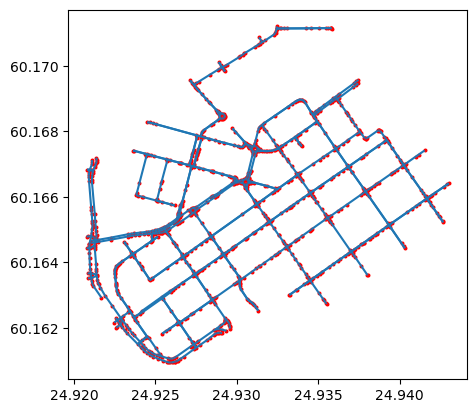

In [9]:
ax = edges.plot()
ax = nodes.plot(ax=ax, color="red", markersize=3.5)

Okay, now we have drivable roads as a GeoDataFrame for the Kamppi district of Helsinki. If you look at the GeoDataFrame, we can see that `osmnx` has also calculated us the `length` of each road segment (presented in meters). The geometries are presented here as `LineString` objects. 

In OSM, the information about the allowed direction of movement is stored in column `oneway`. Let's take a look what kind of values we have in that column:

In [10]:
edges["oneway"].unique()

array([ True, False])

As we can see the unique values in that column are `True` and `False`. This information can be used to construct a `directed` graph for routing by car. For walking and cycling, you typically want create a `bidirectional` graph, because the travel is typically allowed in both directions at least in Finland. Notice, that the rules vary by country, e.g. in Copenhagen you have oneway rules also for bikes but typically each road have the possibility to travel both directions (you just need to change the side of the road if you want to make a U-turn). Column `maxspeed` contains information about the speed limit for given road:

In [12]:
edges["maxspeed"].unique()

array(['40', '50', '30', nan], dtype=object)

As we can see, there are also `None` values in the data, meaning that the speed limit has not been tagged for some roads. This is typical, and often you need to fill the non existing speed limits yourself. This can be done by taking advantage of the road class that is always present in column `highway`:

In [13]:
edges["highway"].unique()

array(['primary', 'secondary', 'tertiary', 'unclassified', 'residential',
       'living_street', 'primary_link'], dtype=object)

Based on these values, we can make assumptions that e.g. `residential` roads in Helsinki have a speed limit of 30 kmph. Hence, this information can be used to fill the missing values in `maxspeed`. 

The second dataset that we extracted from the graph are `nodes`:

In [14]:
nodes.head()

,y,x,street_count,railway,highway,ref,geometry
osmid,,,,,,,
25216594,60.164794,24.921057,4,NaN,NaN,NaN,POINT (24.92106 60.16479)
25216597,60.164683,24.921468,2,NaN,NaN,NaN,POINT (24.92147 60.16468)
25216605,60.164620,24.921489,2,NaN,NaN,NaN,POINT (24.92149 60.16462)
25238874,60.163663,24.921029,4,tram_level_crossing,NaN,NaN,POINT (24.92103 60.16366)
25238883,60.163452,24.921441,2,NaN,crossing,NaN,POINT (24.92144 60.16345)


As we can see, the `nodes` GeoDataFrame contains information about the coordinates of each node as well as a unique `id` for each node. These `id` values are used to determine the connectivity in our network. Hence, `pyrosm` has also added two columns to the `edges` GeoDataFrame that specify **from** and **to** ids for each edge. Column `u` contains information about the **from-id** and column `v` about the **to-id** accordingly:

Okay, as we can see now we have both the roads (i.e. *edges*) and the nodes that connect the street elements together (in red color in the previous figure) that are typically intersections. However, we can see that many of the nodes are in locations that are clearly not intersections. This is intented behavior to ensure that we have full **connectivity** in our network. We can at later stage clean and simplify this network by merging all roads that belong to the same link (i.e. street elements that are between two intersections) which also reduces the size of the network. 

```{note} 

In OSM, the street topology is typically not directly suitable for graph traversal due to missing nodes at intersections which means that the roads are not splitted at those locations. The consequence of this, is that it is not possible to make a turn if there is no intersection present in the data structure. Hence, `pyrosm` will separate all road segments/geometries into individual rows in the data. 
```

## 2. Modify the data

At this stage, we have the necessary components to build a routable graph (nodes and edges) based on distance. However, in real life the network distance is not the best cost metric to use, because the shortest path (based on distance) is not necessarily always the optimal route in terms of **travel time**. Time is typically the measure that people value more (plus it is easier to comprehend), so at this stage we want to **add a new cost attribute** to our edges GeoDataFrame that converts the metric distance information to travel time (in seconds) based on following formula:

 - `<distance-in-meters> / (<speed-limit-kmph> / 3.6)`
 
Before we can do this calculation, we need to ensure that all rows in `maxspeed` column have information about the speed limit. Let's check the value counts of the column and also include information about the `NaN` values with `dropna` parameter:

In [15]:
# Count values
edges["maxspeed"].value_counts(dropna=False)

maxspeed
30     1666
40       93
NaN      52
50       16
Name: count, dtype: int64

As we can see, the rows which do not contain information about the speed limit is the second largest group in our data. Hence, we need to apply a criteria to fill these gaps. We can do this based on following "rule of thumb" criteria in Finland (notice that these vary country by country):

| Road class           | Speed limit within urban region | Speed limit outside urban region |
|----------------------|---------------------------------|----------------------------------|
| motorway             | 100                             | 120                              |
| motorway_link        | 80                              | 80                               |
| trunk                | 60                              | 100                              |
| trunk_link           | 60                              | 60                               |
| primary              | 50                              | 80                               |
| primary_link         | 50                              | 50                               |
| secondary            | 50                              | 50                               |
| secondary_link       | 50                              | 50                               |
| tertiary             | 50                              | 60                               |
| tertiary_link        | 50                              | 50                               |
| unclassified         | 50                              | 80                               |
| unclassified_link    | 50                              | 50                               |
| residential          | 50                              | 80                               |
| living_street        | 20                              | NA                               |
| service              | 30                              | NA                               |
| other                | 50                              | 80                               |

For simplicity, we can consider that all the roads in Helsinki Region follows the *within urban region* speed limits, although this is not exactly true (the higher speed limits start somewhere at the outer parts of the city region). For making the speed limit values more robust / correct, you could use data about urban/rural classification which is available in Finland from [Finnish Environment Institute](https://www.avoindata.fi/data/fi/dataset/kaupunki-maaseutu-luokitus-ykr). Let's first convert our `maxspeed` values to integers using `astype()` method:

In [16]:
edges["maxspeed"] = edges["maxspeed"].astype(float).astype(pd.Int64Dtype())
edges["maxspeed"].unique()

<IntegerArray>
[40, 50, 30, <NA>]
Length: 4, dtype: Int64

As we can see, now the maxspeed values are stored in integer format inside an `IntegerArray`, and the `None` values were converted into `pandas.NA` objects that are assigned with `<NA>`. Now we can create a function that returns a numeric value for different road classes based on the criteria in the table above:

In [17]:
def road_class_to_kmph(road_class):
    """
    Returns a speed limit value based on road class, 
    using typical Finnish speed limit values within urban regions.
    """
    if road_class == "motorway":
        return 100
    elif road_class == "motorway_link":
        return 80
    elif road_class in ["trunk", "trunk_link"]:
        return 60
    elif road_class == "service":
        return 30
    elif road_class == "living_street":
        return 20
    else:
        return 50

Now we can apply this function to all rows that **do not have speed limit information**:

In [18]:
mask = edges["maxspeed"].isnull()

In [19]:
mask

u            v           key
25216594     1372425721  0      False
             352516647   0      False
25216597     1011525999  0      False
25216605     25291516    0      False
25238874     336192701   0      False
                                ...  
11874247042  573263641   0      False
12124374263  775997500   0      False
             3228706311  0      False
12152015326  1371751521  0      False
             3205236838  0      False
Name: maxspeed, Length: 1827, dtype: bool

In [20]:
# Separate rows with / without speed limit information 
mask = edges["maxspeed"].isnull()
edges_without_maxspeed = edges.loc[mask].copy()
edges_with_maxspeed = edges.loc[~mask].copy()

# Apply the function and update the maxspeed
edges_without_maxspeed["maxspeed"] = edges_without_maxspeed["highway"].apply(road_class_to_kmph)
edges_without_maxspeed.head(5).loc[:, ["maxspeed", "highway"]]

,,,maxspeed,highway
u,v,key,,
60072524,303089522,0,20,living_street
60278325,303089524,0,20,living_street
149030036,149030037,0,50,residential
149030037,149030036,0,50,residential
295929863,7690715766,0,20,living_street


Okay, as we can see now the `maxspeed` value have been updated according our criteria, and e.g. the `living_street` road class have been given the speed limit 20 kmph. Now we can recreate the edges GeoDataFrame by combining the two frames: 

In [21]:
edges = pd.concat([edges_with_maxspeed, edges_without_maxspeed])
edges["maxspeed"].unique()

<IntegerArray>
[40, 50, 30, 20]
Length: 4, dtype: Int64

Great, now all of our edges have information about the speed limit. We can also visualize them:

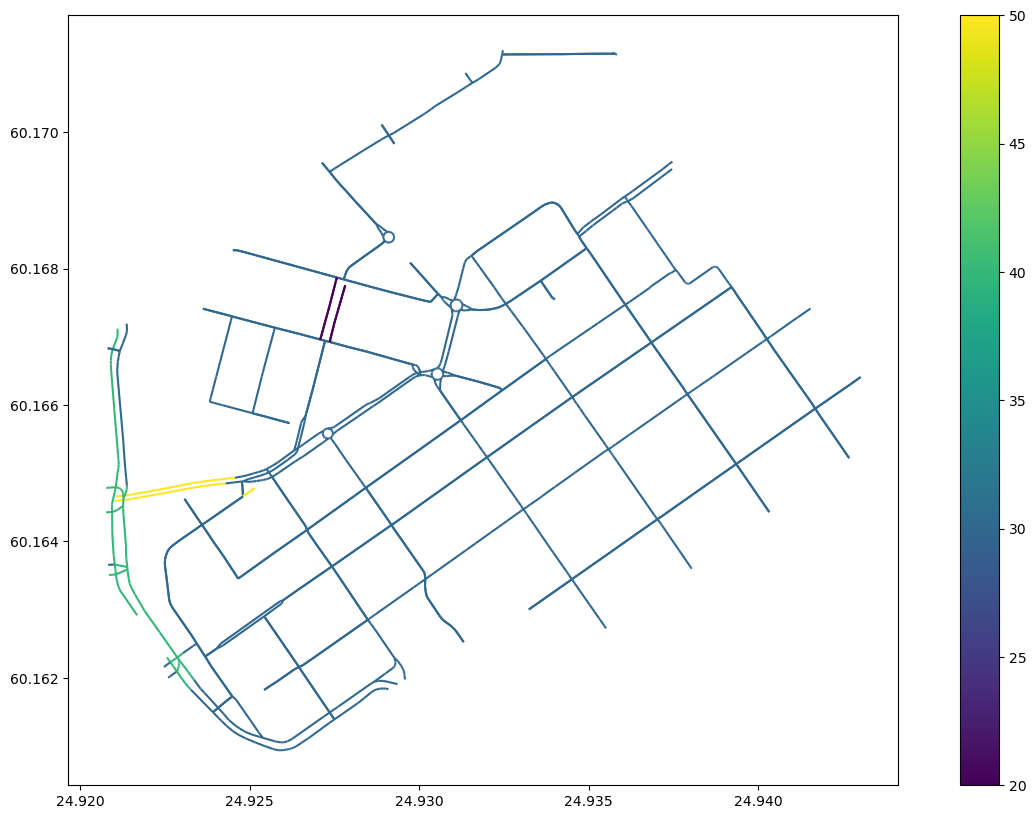

In [23]:
# Convert the value into regular integer Series (the plotting requires having Series instead of IntegerArray) 
edges["maxspeed"] = edges["maxspeed"].astype(int)
ax = edges.plot(column="maxspeed", figsize=(16,10), legend=True)

Finally, we can calculate the travel time in seconds using the formula we saw earlier and add that as a new cost attribute for our network:

In [24]:
edges["travel_time_seconds"] = edges["length"] / (edges["maxspeed"]/3.6)
edges.iloc[0:10, -4:]

width access  \
u        v          key                
25216594 1372425721 0     NaN    NaN   
         352516647  0     NaN    NaN   
25216597 1011525999 0     NaN    NaN   
25216605 25291516   0     NaN    NaN   
25238874 336192701  0     NaN    NaN   
         1519889266 0     NaN    NaN   
25238883 568147264  0     NaN    NaN   
25238899 568147281  0     NaN    NaN   
25238944 319482931  0     NaN    NaN   
         321216337  0     NaN    NaN   

                                                                  geometry  \
u        v          key                                                      
25216594 1372425721 0    LINESTRING (24.92106 60.16479, 24.92087 60.16479)   
         352516647  0    LINESTRING (24.92106 60.16479, 24.92095 60.16456)   
25216597 1011525999 0    LINESTRING (24.92147 60.16468, 24.92106 60.16466)   
25216605 25291516   0    LINESTRING (24.92149 60.16462, 24.92229 60.16469)   
25238874 336192701  0    LINESTRING (24.92103 60.16366, 24.92104 60.16361)   
         1519889266 0    LINESTRING (24.92103 60.16366, 24.92083 60.16366)   
25238883 568147264  0     LINESTRING (24.92144 60.16345, 24.9214 60.16359)   
25238899 568147281  0    LINESTRING (24.92327 60.16204, 24.92319 60.16209)   
25238944 319482931  0     LINESTRING (24.92129 60.16463, 24.92127 60.1647)   
         321216337  0    LINESTRING (24.92129 60.16463, 24.92136 60.16472)   

                         travel_time_seconds  
u        v          key                       
25216594 1372425721 0               0.936336  
         352516647  0               2.364035  
25216597 1011525999 0               1.621367  
25216605 25291516   0               3.232128  
25238874 336192701  0               0.549065  
         1519889266 0               1.306234  
25238883 568147264  0               1.384929  
25238899 568147281  0               0.682915  
25238944 319482931  0               0.729125  
         321216337  0               1.007092

Excellent! Now our GeoDataFrame has all the information we need for creating a graph that can be used to conduct shortest path analysis based on length or travel time. Notice that here we assume that the cars can drive with the same speed as what the speed limit is. Considering the urban dynamics and traffic congestion, this assumption might not hold, but for simplicity, we assume so in this tutorial. 

## 3. Build a routable graph from modified edges with osmnx

We can use `osmnx` library to easily build a directed graph. Let's see how we can create a routable NetworkX graph using `osmnx` with one command:

In [27]:
G = ox.graph_from_gdfs(gdf_nodes=nodes, gdf_edges=edges)
G

Now we have a similar routable graph as in the beginning, but now the network edges contain information about the speed limit for all edges. We can easily visualize the graph with `osmnx` as follows: 

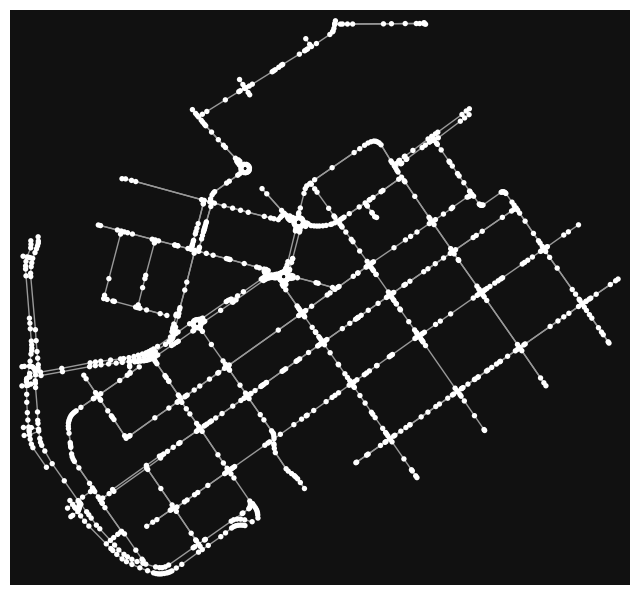

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [35]:
import osmnx as ox 
ox.plot_graph(G)

## 4. Routing with NetworkX

Now we have everything we need to start routing with NetworkX (based on driving distance or travel time). But first, let's again go through some basics about routing.

### Basic logic in routing

Most (if not all) routing algorithms work more or less in a similar manner. The basic steps for finding an optimal route from A to B, is to:
 1. Find the nearest node for origin location \* (+ get info about its node-id and distance between origin and node)
 2. Find the nearest node for destination location \* (+ get info about its node-id and distance between origin and node)
 3. Use a routing algorithm to find the shortest path between A and B
 4. Retrieve edge attributes for the given route(s) and summarize them (can be distance, time, CO2, or whatever)
 
\* in more advanced implementations you might search for the closest edge

This same logic should be applied always when searching for an optimal route between a single origin to a single destination, or when calculating one-to-many -type of routing queries (producing e.g. travel time matrices). 

## Find the optimal route between two locations

Next, we will learn how to find the shortest path between two locations using [Dijkstra's](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) algorithm.

First, let's find the closest nodes for two locations that are located in the area. OSMnx provides a handly function for geocoding an address `ox.geocode()`. We can use that to retrieve the x and y coordinates of our origin and destination.

In [36]:
# OSM data is in WGS84 so typically we need to use lat/lon coordinates when searching for the closest node

# Origin
orig_address = "Ruoholahdenkatu 24, Helsinki"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Annankatu 18, Helsinki"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: 24.9246625 60.1641351
Destination coords: 24.9381701 60.1658212


Okay, now we have coordinates for our origin and destination.

### Find the nearest nodes

Next, we need to find the closest nodes from the graph for both of our locations. For calculating the closest point we use `ox.distance.nearest_nodes()` -function and specify `return_dist=True` to get the distance in meters.

In [37]:
# Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: 10695632364 and distance: 42.309128440708086 meters.
Destination node-id: 3395239427 and distance: 21.53504631607822 meters.


Now we are ready to start the actual routing with NetworkX. 

### Find the fastest route by distance / time

Now we can do the routing and find the shortest path between the origin and target locations
by using the `dijkstra_path()` function of NetworkX. For getting only the cumulative cost of the trip, we can directly use a function `dijkstra_path_length()` that returns the travel time without the actual path. 

With `weight` -parameter we can specify the attribute that we want to use as cost/impedance. We have now three possible weight attributes available: `'length'` and `'travel_time_seconds'`.    

- Let's first calculate the routes between locations by walking and cycling, and also retrieve the travel times

In [38]:
# Calculate the paths 
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

In [39]:
metric_path == time_path

True

In [40]:
travel_length

1024.374734725627

In [41]:
travel_time

122.92496816707522

Okay, that was it! Let's now see what we got as results by visualizing the results.

For visualization purposes, we can use a handy function again from OSMnx called `ox.plot_graph_route()` that plots the route in a simple map:

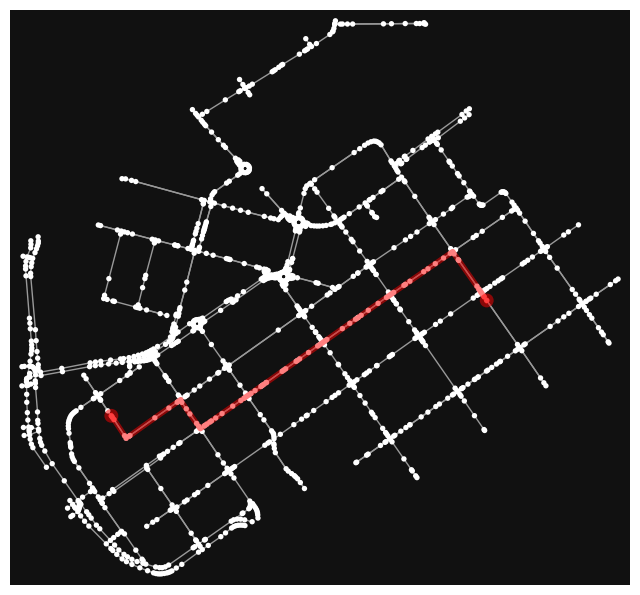

Shortest path distance  1024.4 meters.


In [43]:
# Shortest path based on distance
fig, ax = ox.plot_graph_route(G, metric_path)

# Print some useful information as well
print(f"Shortest path distance {travel_length: .1f} meters.")

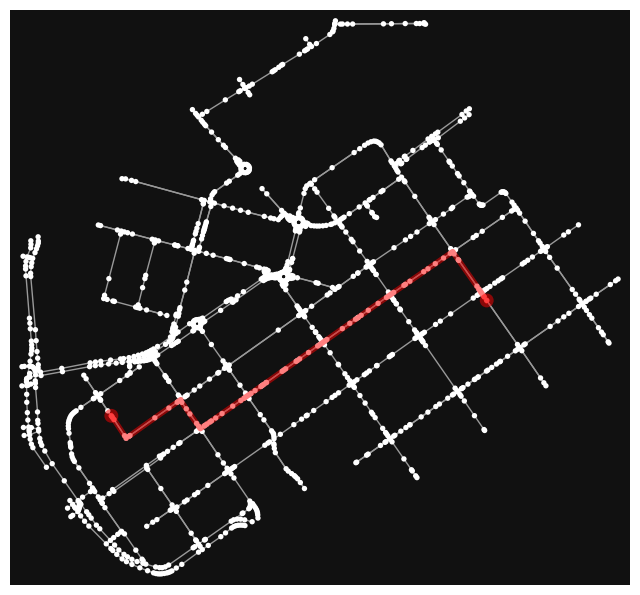

Shortest path time  2.0 minutes.


In [45]:
fig, ax = ox.plot_graph_route(G, time_path)

# Print some useful information as well
print(f"Shortest path time {travel_time/60: .1f} minutes.")


Great! Now we have successfully found the optimal route between our origin and destination and we also have estimates about the travel time that it takes to travel between the locations by driving. As we can see, the route optimized based on travel time and distance were exactly the same which is natural, as the network here is relatively small and there are no big differences in the speed limits. However, with larger networks, you might get alternating routes as travelling e.g. via ring roads is typically faster than driving throught the city (as an example). 